# Exploring dynamic difficulty adjustment (adaptive habit target logic)

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
from dataclasses import dataclass
from typing import List, Optional, Tuple
from datetime import date, datetime

### Data classes

In [201]:
@dataclass
class DataPoint:
    log_date: Optional[date] = None
    # difficulty: Optional[int] = None    # User-inserted value of percieved difficulty (easy, moderate, or hard).
    value: Optional[float] = None
    target: Optional[float] = None

@dataclass
class History:
    data_points: List[DataPoint]
    alpha: float

### Load dataset

In [202]:
df = pd.read_csv("data/01_dataset.csv")
df['log_date'] = pd.to_datetime(df['log_date'])
df.columns = df.columns.str.strip()

### Plotting dataset

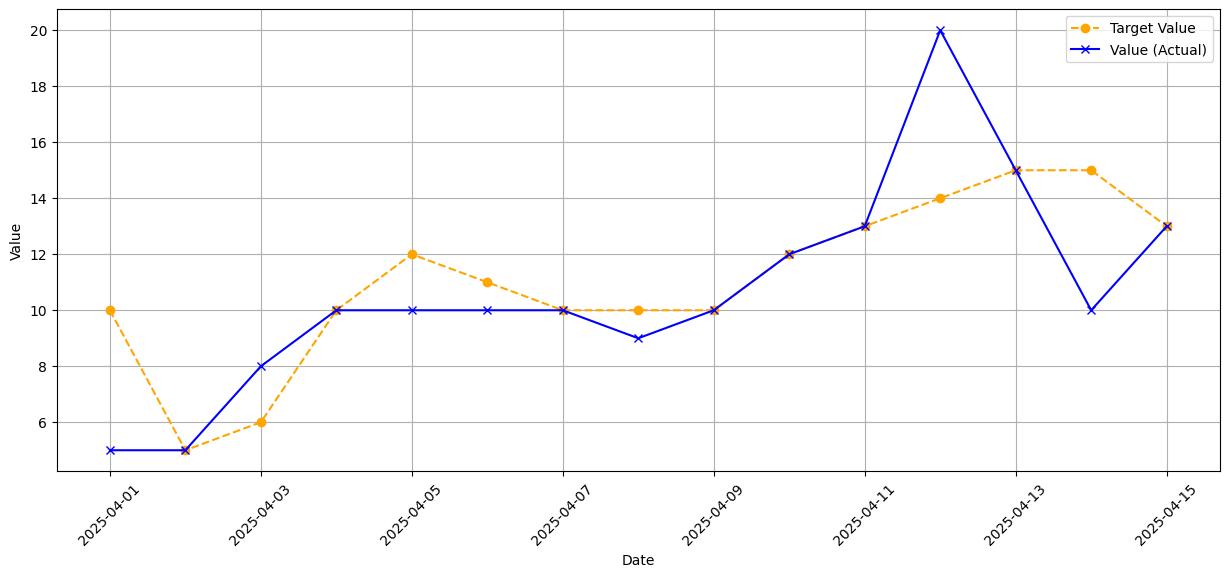

In [203]:
plt.figure(figsize=(15, 6))
plt.plot(df['log_date'], df['target'], label='Target Value', color='orange', linestyle='--', marker='o')
plt.plot(df['log_date'], df['value'], label='Value (Actual)', color='blue', marker='x')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

## Holt's Linear Trend 
*aka Double Exponential Smoothing*, extends simple exponential smoothing of time series data with an underlying trend. Unlike moving average Holt's Linear Trend capture the rate of change, or trend, in the data. Used to forecast data.

**Definition:**
- $L_t$ (Level)
- $T_t$ (Trend)
- $\alpha \in [0, 1]$ (Smoothing for level)
- $\beta \in [0, 1]$ (Smoothing for trend)
- $Y_t$: (Actual Value)

$$\textbf{Level Equation:}$$
$$L_t = \alpha Y_t + (1 - \alpha)(L_{t-1} + T_{t-1})$$

$$\textbf{Trend Equation:}$$
$$T_t = \beta (L_t - L_{t-1}) + (1 - \beta)T_{t-1}$$

$$\textbf{Forecast Equation:}$$
$$\hat{Y}_{t+h} = L_t + (h \times T_t)$$

In [204]:
def hlt(
    old_l: float, 
    old_t: float, 
    a: float,
    b: float,
    y: float,
):
    h = 1
    l = a*y + (1 - a)*(old_l + old_t)
    t = b*(l - old_l) + (1 - b)*old_t
    new_y = l + (h*t)
    return l, t, new_y

In [205]:
ALPHA: float = 0.2
BETA: float = 0.4
level = df['value'].iloc[0]
trend = df['value'].iloc[1] - df['value'].iloc[0]

forecasts = [None]
first_forecast = level + trend
forecasts.append(first_forecast)

for i in range(1, len(df)):
    y = df['value'].iloc[i]
    level, trend, next_y = hlt(level, trend, ALPHA, BETA, y)
    forecasts.append(next_y)

last_date = df['log_date'].iloc[-1]
new_row = pd.DataFrame({'log_date': [last_date + pd.Timedelta(days=1)]})
df = pd.concat([df, new_row], ignore_index=True)

df['holt'] = forecasts
#df['diff'] = df['value'] - df['target']

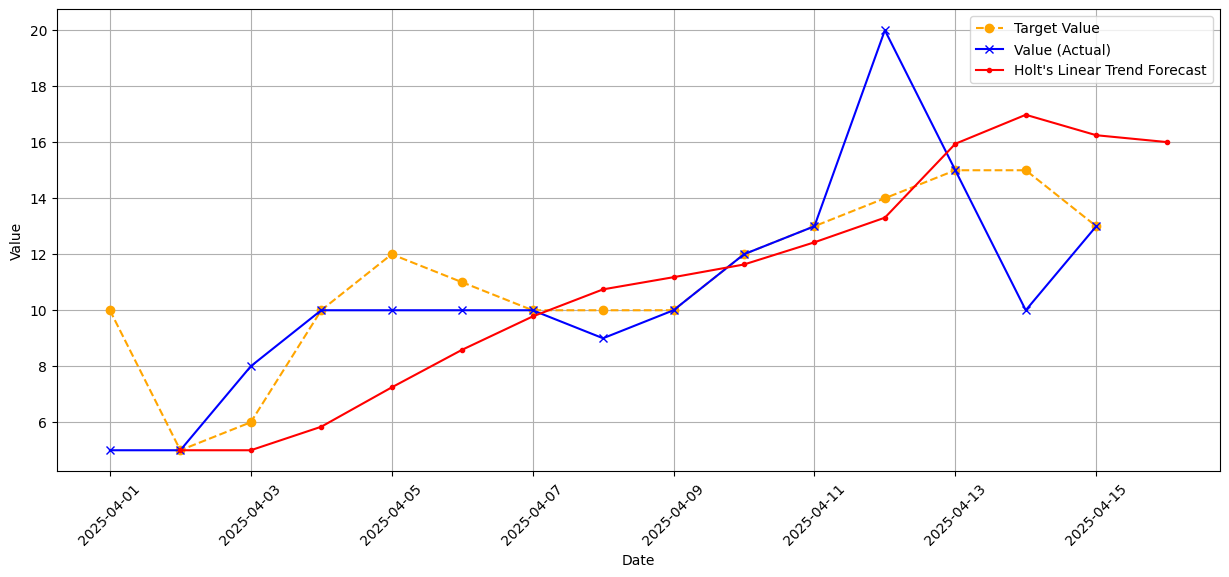

In [206]:
plt.figure(figsize=(15, 6))

plt.plot(df['log_date'], df['target'], label='Target Value', color='orange', linestyle='--', marker='o')
plt.plot(df['log_date'], df['value'], label='Value (Actual)', color='blue', marker='x')
plt.plot(df['log_date'], df['holt'], label="Holt's Linear Trend Forecast", color='red', marker='.')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

## "Rubber Banding"
*A mechanic from the game Mario Kart that regulate the difficulty to keep the player engaged.* It's a form of Dynamic Difficulty Adjustment (DDA), and the goal is to keep the racers (racecar players) close together, like they are connected by a rubber band. Far ahead? ...speeds the others up, far behind? ...slows the others down, to let you catch up.

Inputs:
- $R$ (Rank)
- $\Delta d$: Distance difference
- $k \in [0,1]$: (Elasticity Coefficient)

Bot Velocity Equation:

Let $v_t$ be the new velocity and $v_0$ be the default velocity.
$$\text{Rank Scalar: } \lambda = R \cdot k \quad$$
$$v_t = v_0 \times (1 + \lambda \cdot \Delta d)$$

### Applied to habit targets
If we apply this method to the target adaptation, we compute next target instead of racing bot velocity.

**Definition:**
- $H_t$ (Holt's Linear Trend Forecast): Acts as the user's predicted *'true capability'*.
- $Y_t$ (Actual Value)
- $V_t$ (Target)
- $k$ (Elasticity Coefficient)

$$\text{Next Target Equation:}$$
$$V_t = H_t \times \left(1 + k \cdot \frac{Y_{t-1} - V_{t-1}}{V_{t-1}} \right)$$

The "rank" could later be the User-inserted value of percieved difficulty (easy, moderate, or hard). Or "rank" could be a measurement of 'Last week's performance compared to last 3 months'. The third alternative is to let "rank" be the 'current measured consistency'. "Rank" would then modulate $k$.

In [207]:
def target_rubber_band(
    h: float,
    old_value: float,
    old_target: float,
    k: float
):
    completion: float = old_value - old_target
    completion_percentage: float = completion / old_target
    new_target = h * (1 + k*completion_percentage)
    return new_target

In [208]:
ELASTICITY: float = 0.8
ALPHA: float = 0.2
BETA: float = 0.4
level = df['value'].iloc[0]
trend = df['value'].iloc[1] - df['value'].iloc[0]

rb_targets = [None]
forecasts = [None]
first_forecast = level + trend
forecasts.append(first_forecast)
rb_targets.append(None)

for i in range(1, len(df)):
    value = df['value'].iloc[i]
    level, trend, next_holt = hlt(level, trend, ALPHA, BETA, value)
    forecasts.append(next_holt)

    target = df['target'].iloc[i]
    next_target = target_rubber_band(next_holt, value, target, ELASTICITY)
    rb_targets.append(next_target)

last_date = df['log_date'].iloc[-1]
new_row = pd.DataFrame({'log_date': [last_date + pd.Timedelta(days=1)]})
df = pd.concat([df, new_row], ignore_index=True)

df['holt'] = forecasts
df['rb_target'] = rb_targets
#df['diff'] = df['value'] - df['target']

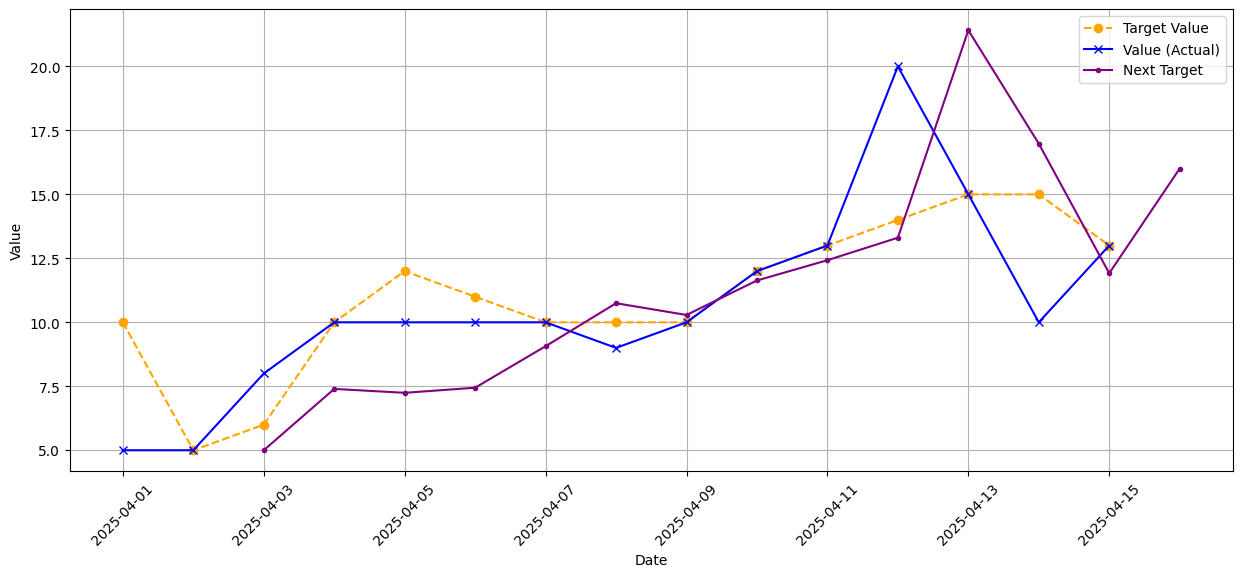

In [209]:
plt.figure(figsize=(15, 6))

plt.plot(df['log_date'], df['target'], label='Target Value', color='orange', linestyle='--', marker='o')
plt.plot(df['log_date'], df['value'], label='Value (Actual)', color='blue', marker='x')
# plt.plot(df['log_date'], df['holt'], label="Holt's Linear Trend Forecast", color='red', marker='.')
plt.plot(df['log_date'], df['rb_target'], label="Next Target", color='purple', marker='.')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

### Asymmetric Elasticity
As seen in the plot above, the calculation of the next target, using the rubber band method, were a bit too sensitive to high "spikes" and not enough elastic when user performs under the target.

To solve this we intruduce two different Elasticity Coefficients for values above target and values below target.

For exmaple:
- $k_{below} = 0.9$ (Case: user is failing. Result: drop target fast)
- $k_{above} = 0.1$ (Case: user is succeeding. Result: dampen high spikes / less elastic)

In [210]:
def target_rubber_band_v2(
    h: float,
    old_value: float,
    old_target: float,
    k_above: float,
    k_below: float
):
    completion: float = old_value - old_target
    completion_percentage: float = completion / old_target

    k = 0.5
    if completion_percentage < 0:
        k = k_below
    else:
        k = k_above
    
    new_target = h * (1 + k*completion_percentage)
    return new_target

In [213]:
ELASTICITY_BELOW: float = 0.9
ELASTICITY_ABOVE: float = 0.1
ALPHA: float = 0.2
BETA: float = 0.4
level = df['value'].iloc[0]
trend = df['value'].iloc[1] - df['value'].iloc[0]

rb_targets = [None]
forecasts = [None]
first_forecast = level + trend
forecasts.append(first_forecast)
rb_targets.append(None)

for i in range(1, len(df)):
    value = df['value'].iloc[i]
    level, trend, next_holt = hlt(level, trend, ALPHA, BETA, value)
    forecasts.append(next_holt)

    target = df['target'].iloc[i]
    next_target = target_rubber_band_v2(
        next_holt, value, target, ELASTICITY_ABOVE, ELASTICITY_BELOW
    )
    rb_targets.append(next_target)

last_date = df['log_date'].iloc[-1]
new_row = pd.DataFrame({'log_date': [last_date + pd.Timedelta(days=1)]})
df = pd.concat([df, new_row], ignore_index=True)

df['holt'] = forecasts
df['rb_target'] = rb_targets
#df['diff'] = df['value'] - df['target']

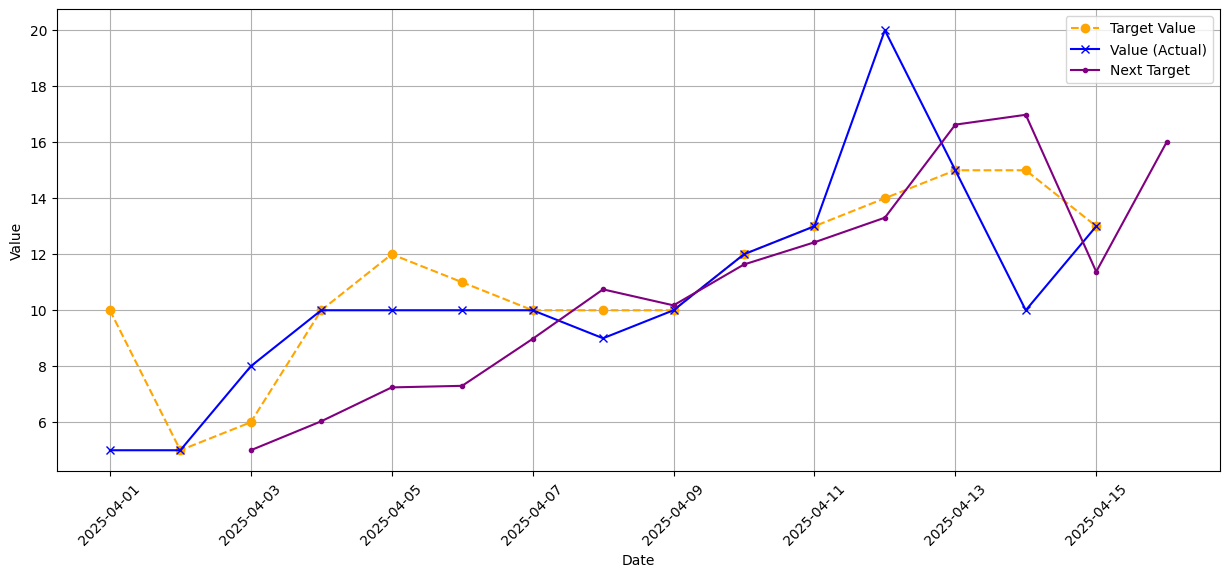

In [214]:
plt.figure(figsize=(15, 6))

plt.plot(df['log_date'], df['target'], label='Target Value', color='orange', linestyle='--', marker='o')
plt.plot(df['log_date'], df['value'], label='Value (Actual)', color='blue', marker='x')
# plt.plot(df['log_date'], df['holt'], label="Holt's Linear Trend Forecast", color='red', marker='.')
plt.plot(df['log_date'], df['rb_target'], label="Next Target", color='purple', marker='.')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()